# Importing Data


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# So it is pretty much impossible to share datasets over google drive unless you have a shared drive
# But Colab lets you directly clone git repos, so just run this block
import time

start_time = time.time()

!git clone https://github.com/Sidd-T/APS360-Pokemon-Data.git

end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

#After this the files should be in the session

Cloning into 'APS360-Pokemon-Data'...
remote: Enumerating objects: 40741, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 40741 (delta 5), reused 14 (delta 2), pack-reused 40724
Receiving objects: 100% (40741/40741), 736.35 MiB | 38.32 MiB/s, done.
Resolving deltas: 100% (958/958), done.
Checking out files: 100% (48377/48377), done.
Total time elapsed: 27.26 seconds


In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

import pandas as pd

In [ ]:
pokemon_ordered = pd.read_csv('/content/APS360-Pokemon-Data/labelled_set/pokemon.csv')
pokemon_ordered = pokemon_ordered[["Name", "Type1", "Type2"]]
pokemon_t1 = pd.read_csv('/content/APS360-Pokemon-Data/labelled_set/pokemon_by_primary_type.csv')
pokemon_t2 = pd.read_csv('/content/APS360-Pokemon-Data/labelled_set/pokemon_with_secondary_type_sorted.csv')

In [ ]:
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join

catcols = ["Bug", "Dark", "Dragon", "Electric", "Fairy", "Fighting", "Fire", "Flying", "Ghost", 
           "Grass","Ground", "Ice", "Normal", "Poison", "Psychic", "Rock", "Steel", "Water"]

img_path = []
names = []

IMG_DIR = '/content/APS360-Pokemon-Data/labelled_set/images'

files = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]
for img in files:
    pokemon_name = img.split('.')
    path = IMG_DIR +'/' +str(img)
    img_path.append(path)
    names.append(pokemon_name[0])

img_df = pd.DataFrame([])
img_df['img_path'] = img_path
img_df['Name'] = names

img_df[:9]

,img_path,Name
0,/content/APS360-Pokemon-Data/labelled_set/imag...,crustle
1,/content/APS360-Pokemon-Data/labelled_set/imag...,carracosta
2,/content/APS360-Pokemon-Data/labelled_set/imag...,claydol
3,/content/APS360-Pokemon-Data/labelled_set/imag...,magmortar
4,/content/APS360-Pokemon-Data/labelled_set/imag...,grovyle
5,/content/APS360-Pokemon-Data/labelled_set/imag...,sliggoo
6,/content/APS360-Pokemon-Data/labelled_set/imag...,crabominable
7,/content/APS360-Pokemon-Data/labelled_set/imag...,kabuto
8,/content/APS360-Pokemon-Data/labelled_set/imag...,unown


In [ ]:
type_num = []
image = []

for i, row in pokemon_ordered.iterrows():
  type_num.append(catcols.index(row["Type1"]))
  for j, row2 in img_df.iterrows():
    if row["Name"] == row2["Name"]:
      path = row2["img_path"]
      break
    else:
      continue
  image.append(path)  

pokemon_ordered["type_num"] = type_num
pokemon_ordered["image"] = image

sub_po = pokemon_ordered[["image", "type_num"]]
sub_po[:9]

,image,type_num
0,/content/APS360-Pokemon-Data/labelled_set/imag...,9
1,/content/APS360-Pokemon-Data/labelled_set/imag...,9
2,/content/APS360-Pokemon-Data/labelled_set/imag...,9
3,/content/APS360-Pokemon-Data/labelled_set/imag...,6
4,/content/APS360-Pokemon-Data/labelled_set/imag...,6
5,/content/APS360-Pokemon-Data/labelled_set/imag...,6
6,/content/APS360-Pokemon-Data/labelled_set/imag...,17
7,/content/APS360-Pokemon-Data/labelled_set/imag...,17
8,/content/APS360-Pokemon-Data/labelled_set/imag...,17


In [ ]:
image[721:724] #checking if the jpgs were inputted properly

['/content/APS360-Pokemon-Data/labelled_set/images/rowlet.jpg',
 '/content/APS360-Pokemon-Data/labelled_set/images/dartrix.jpg',
 '/content/APS360-Pokemon-Data/labelled_set/images/decidueye.jpg']

In [ ]:
import os

os.mkdir('/content/APS360-Pokemon-Data/labels')

In [ ]:
parent_path = '/content/APS360-Pokemon-Data/labels/'
for i in range(18):
  dir_path = parent_path + str(i)
  print(dir_path)
  os.mkdir(dir_path)

/content/APS360-Pokemon-Data/labels/0
/content/APS360-Pokemon-Data/labels/1
/content/APS360-Pokemon-Data/labels/2
/content/APS360-Pokemon-Data/labels/3
/content/APS360-Pokemon-Data/labels/4
/content/APS360-Pokemon-Data/labels/5
/content/APS360-Pokemon-Data/labels/6
/content/APS360-Pokemon-Data/labels/7
/content/APS360-Pokemon-Data/labels/8
/content/APS360-Pokemon-Data/labels/9
/content/APS360-Pokemon-Data/labels/10
/content/APS360-Pokemon-Data/labels/11
/content/APS360-Pokemon-Data/labels/12
/content/APS360-Pokemon-Data/labels/13
/content/APS360-Pokemon-Data/labels/14
/content/APS360-Pokemon-Data/labels/15
/content/APS360-Pokemon-Data/labels/16
/content/APS360-Pokemon-Data/labels/17


In [ ]:
import shutil

for i, row in sub_po.iterrows():
  src = row["image"]
  dest = '/content/APS360-Pokemon-Data/labels/' + str(row["type_num"])
  shutil.copy2(src, dest)

In [ ]:
def getTypeFromNum(num):
  type_code = pokemon_ordered.loc[num-1].at["type_num"]
  return type_code

In [ ]:
def catagorizeFolder(IMG_DIR):
  img_path = []
  numbers = []

  files = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]
  for img in files:
      num = img.split('.')
      num = num[0]
      if re.search('-', num):
        num = num.split('-')
        num = num[0]
      if re.search('f', num):
        num = num.split('f')
        num = num[0]
      if num.isnumeric():
        num = int(num)
      else:
        continue;
      if (num > 809 or num < 1):
        continue;
      else:
        path = IMG_DIR +'/' +str(img)
        img_path.append(path)
        numbers.append(num)

  img_df = pd.DataFrame([])
  img_df['img_path'] = img_path
  img_df['idx'] = numbers
  print(img_df[:3])

  for i, row in img_df.iterrows():
    src = row["img_path"]
    dest = '/content/APS360-Pokemon-Data/labels/' + str(getTypeFromNum(row["idx"])) +'/'+ str(row["idx"])
    if IMG_DIR == '/content/APS360-Pokemon-Data/sprites':
      dest += "-sprites"
    elif IMG_DIR == '/content/APS360-Pokemon-Data/extra_data/back':
      dest += "-back"
    elif IMG_DIR == '/content/APS360-Pokemon-Data/extra_data/other/home':
      dest += "-3d"
    #i dont know why this didnt work with src[-4:-1]
    dest += src[-4]
    dest += src[-3]
    dest += src[-2]
    dest += src[-1]
    shutil.copyfile(src, dest)

#Make sure to not include the ending /, that is adding in the function
catagorizeFolder('/content/APS360-Pokemon-Data/pokemon_jpg')
catagorizeFolder('/content/APS360-Pokemon-Data/sprites')
catagorizeFolder('/content/APS360-Pokemon-Data/extra_data/back')
catagorizeFolder('/content/APS360-Pokemon-Data/extra_data/other/home')

                                           img_path  idx
0  /content/APS360-Pokemon-Data/pokemon_jpg/568.jpg  568
1   /content/APS360-Pokemon-Data/pokemon_jpg/73.jpg   73
2   /content/APS360-Pokemon-Data/pokemon_jpg/33.jpg   33
                                            img_path  idx
0       /content/APS360-Pokemon-Data/sprites/749.png  749
1        /content/APS360-Pokemon-Data/sprites/40.png   40
2  /content/APS360-Pokemon-Data/sprites/773-psych...  773
                                            img_path  idx
0  /content/APS360-Pokemon-Data/extra_data/back/7...  749
1  /content/APS360-Pokemon-Data/extra_data/back/4...   40
2  /content/APS360-Pokemon-Data/extra_data/back/8...    8
                                            img_path  idx
0  /content/APS360-Pokemon-Data/extra_data/other/...  749
1  /content/APS360-Pokemon-Data/extra_data/other/...   40
2  /content/APS360-Pokemon-Data/extra_data/other/...  773


In [ ]:
def get_data_loader(batch_size, path='/content/APS360-Pokemon-Data/labels/'):
    torch.manual_seed(0)
    
    # these are prerequisite for using googleNet, according to https://pytorch.org/hub/pytorch_vision_googlenet/
    # challenge 1 (image small)
    transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])

    fullset = torchvision.datasets.ImageFolder(root=path, transform=transform)

    #from lab 2, 2/3 is training, 1/6 is test, 1/6 is val

    trainSetSize = int(len(fullset) * 2 / 3)
    valSetSize = int(len(fullset) * 1 / 6)
    testSetSize = len(fullset) - trainSetSize - valSetSize

    train_set, val_set, test_set = data.random_split(fullset, [trainSetSize, valSetSize, testSetSize])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,num_workers=1)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,num_workers=1)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,num_workers=1)
    # length of loader is how many batches the set was split into
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(32)

In [ ]:
"""
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    image = images[0]
    print(image.shape)
    img = np.transpose(image, [1,2,0])

    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    print(labels[0])

    k += 1
    if k > 14:
        break
"""

# Main Model

## Helper functions

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# helper functions

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "/content/gdrive/MyDrive/Project/modelCheckPoints/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_corr = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        pred = outputs.max(1, keepdim=True)[1]
        total_corr += pred.eq(labels.view_as(pred)).sum().item()
        
        total_epoch += len(labels)
    acc = float(total_corr) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

# Training Curve
def plot_training_curve(path, doValidation=True):
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    if doValidation:
        plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    if doValidation:
        plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train(model, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=24, doValidation=True):
    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # arrays for keeping track of things
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_corr = 0.0
        total_epoch = 0

        i = 0
        for imgs, labels in train_loader: # this for loop takes a long time to load all images in first iteration
            #imgs, labels = data
            #print(i)
            # gradient descent
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            pred = out.max(1, keepdim=True)[1]
            total_train_corr += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += len(labels)
            i+=1
            
        train_acc[epoch] = float(total_train_corr) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        if doValidation:
            val_acc[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} | "+
               "Validation Accuracy: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
  
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
class mainClassifier(nn.Module):
    def __init__(self):
        super(mainClassifier, self).__init__()
        self.name = "mainClassifier3Layer"
        self.fc1 = nn.Linear(1024, 500)
        self.fc2 = nn.Linear(500, 180)
        self.fc3 = nn.Linear(180, 18)

    def forward(self, x):
        flattened = x.view(-1, 1024)
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# reducing to 2 layer doesn't help
class smallClassifier(nn.Module):
    def __init__(self):
        super(smallClassifier, self).__init__()
        self.name = "smallClassifier2Layer"
        self.fc1 = nn.Linear(1024, 500)
        self.fc2 = nn.Linear(500, 18)

    def forward(self, x):
        flattened = x.view(-1, 1024)
        x = F.relu(self.fc1(flattened))
        x = self.fc2(x)
        return x

## Overfitting a small data set
Sanity check with a small dataset containting 3 entry per category

In [ ]:
torch.manual_seed(0)

# these are prerequisite for using googleNet, according to https://pytorch.org/hub/pytorch_vision_googlenet/
# challenge 1 (image small)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

smallSet = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/Project/smallDataSet', transform=transform)

In [ ]:
small_loader = torch.utils.data.DataLoader(smallSet, batch_size=1)
print(len(small_loader))

# There are 3 * 18 = 54 images in small data set 

54


In [ ]:
# visualize dataset
"""
import matplotlib.pyplot as plt

k = 0
for images, labels in small_loader:
    image = images[0]
    print(image.shape)
    img = np.transpose(image, [1,2,0])

    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    #print(labels[0])

    k += 1
    if k > 14:
        break
"""

In [ ]:
# extract embedding for the small data set
small_loader = torch.utils.data.DataLoader(smallSet, batch_size=54)
# Saving the computed features
smallSetEmbedding = []


for imgs, labels in small_loader:
    oneEmbedding = torch.zeros(54, 1024)
    print(oneEmbedding.shape)
    # Define a function that will copy the output of a layer
    
    # Attach that function to our selected layer
    h = googleNetFeatureLayer.register_forward_hook(copy_data)
    googelNet(imgs)
    h.remove()

    oneEmbedding = torch.from_numpy(oneEmbedding.detach().numpy())
    smallSetEmbedding.append([oneEmbedding, labels])

#torch.save(smallSetEmbedding, '/content/gdrive/MyDrive/Project/smallDataSet/smallSetEmbedding')

#alexTrain is a list of pyTorch tensor + label

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


torch.Size([54, 1024])


In [ ]:
for imgs, labels in smallSetEmbedding:
    print(len(labels), "\n", labels)
    print(imgs.shape, "\n", imgs)

54 
 tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17])
torch.Size([54, 1024]) 
 tensor([[0.5448, 0.0310, 0.5322,  ..., 0.4206, 0.0842, 0.1183],
        [0.4397, 0.0426, 0.0021,  ..., 0.5649, 0.2392, 0.0336],
        [0.1284, 0.0569, 0.0060,  ..., 0.5222, 0.2627, 0.2451],
        ...,
        [0.9123, 0.0289, 0.0044,  ..., 0.3866, 0.5468, 0.0928],
        [0.6563, 0.0276, 0.0501,  ..., 0.4558, 0.7915, 0.0168],
        [0.0924, 0.0562, 0.0000,  ..., 0.9281, 0.0981, 0.0407]])


In [ ]:
smallSetEmbedding = torch.load('/content/gdrive/MyDrive/Project/smallDataSet/smallSetEmbedding')

classifier = mainClassifier()
train(classifier, train_loader=smallSetEmbedding, val_loader=[], batch_size = 54, learning_rate=0.005, num_epochs = 200)

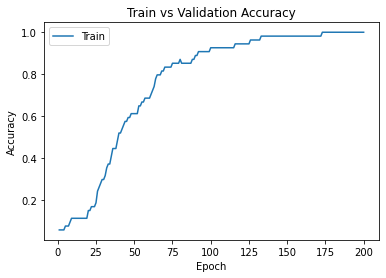

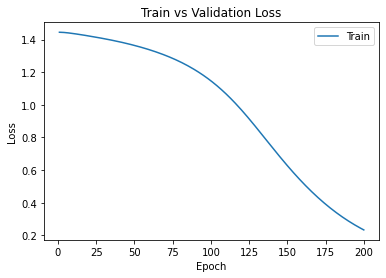

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 54, epoch = 199, learning_rate=0.005)
plot_training_curve(model_path, doValidation=False)

## Initial testing

In [ ]:
import torch
googelNet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
googelNet.eval() # needed so we don't dropout when extracting feature
# from .eval, we see that our fc layer should have input dimension = 1024 (challenge 2)

# from https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
googleNetFeatureLayer = googelNet._modules.get('dropout')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
def loaderToEmbedding(loader, name):
    loaderEmbedding = []
    for imgs, labels in loader:
        #embedding = torch.zeros(1024)
        # Define a function that will copy the output of a layer (must re-import GoogleNet if this is updated, even just for diff batch size)
        def copy_data(m, i, o):
            embedding = o.data.detach().clone()
            loaderEmbedding.append([embedding, labels])
        # Attach that function to our selected layer
        h = googleNetFeatureLayer.register_forward_hook(copy_data)
        googelNet(imgs)
        h.remove()

        #print(loaderEmbedding)

    torch.save(loaderEmbedding, '/content/gdrive/MyDrive/Project/embeddings/' + name)

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(64)

In [ ]:
loaderToEmbedding(train_loader, "train64")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
trainEmedding = torch.load('/content/gdrive/MyDrive/Project/embeddings/' + "train64")


for imgs, labels in trainEmedding:
    print(labels.shape, "\n", labels)
    print(imgs.shape, "\n", imgs)

In [ ]:
loaderToEmbedding(val_loader, "val64")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
loaderToEmbedding(test_loader, "test64")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
trainEmedding = torch.load('/content/gdrive/MyDrive/Project/embeddings/' + "train64")
valEmedding = torch.load('/content/gdrive/MyDrive/Project/embeddings/' + "val64")

classifier = mainClassifier()
train(classifier, train_loader=trainEmedding, val_loader=valEmedding, batch_size = 64, learning_rate=0.0008 , num_epochs = 200)

Epoch 1: Train acc: 0.153639846743295, Train loss: 2.6241763886951266 | Validation Accuracy: 0.16717791411042945, Validation loss: 2.653122728521174
Epoch 2: Train acc: 0.22413793103448276, Train loss: 2.4519626640138172 | Validation Accuracy: 0.21932515337423314, Validation loss: 2.501238562844016
Epoch 3: Train acc: 0.28084291187739463, Train loss: 2.2696093037014915 | Validation Accuracy: 0.2837423312883436, Validation loss: 2.3660077398473565
Epoch 4: Train acc: 0.32298850574712645, Train loss: 2.125576655069987 | Validation Accuracy: 0.294478527607362, Validation loss: 2.3220049901442095
Epoch 5: Train acc: 0.36053639846743296, Train loss: 1.9980024553480602 | Validation Accuracy: 0.3174846625766871, Validation loss: 2.305973627350547
Epoch 6: Train acc: 0.3988505747126437, Train loss: 1.8810812518710183 | Validation Accuracy: 0.3282208588957055, Validation loss: 2.2752188335765493
Epoch 7: Train acc: 0.43908045977011495, Train loss: 1.768042606966836 | Validation Accuracy: 0.3389

KeyboardInterrupt: ignored

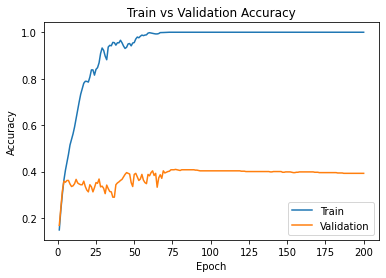

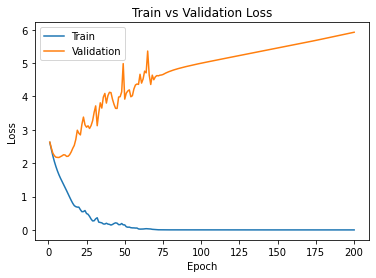

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 64, epoch = 199, learning_rate=0.001)
plot_training_curve(model_path)

# swichted to adam
# best at Epoch 74: Train acc: 1.0, Train loss: 0.002755338741865541 | Validation Accuracy: 0.40797546012269936, Validation loss: 4.64330133524808
# Test accuracy is 0.3981623277182236 Test loss is 4.424333203922618

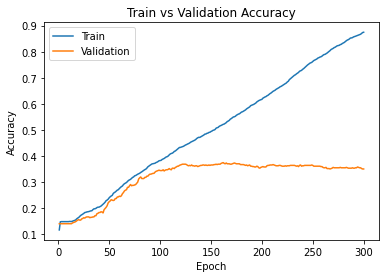

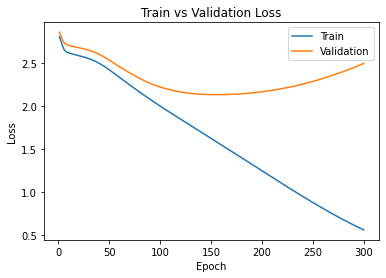

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 64, epoch = 299, learning_rate=0.0007)
plot_training_curve(model_path)

# best at Epoch 162: Train acc: 0.5210727969348659, Train loss: 1.5365643217450096 | Validation Accuracy: 0.37423312883435583, Validation loss: 2.1333358504555444
# Test accuracy is 0.33078101071975496 Test loss is 2.1828402172435415

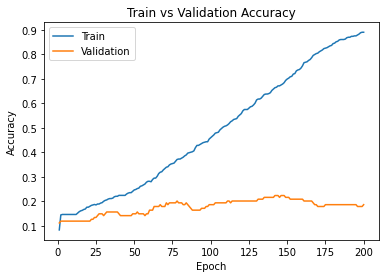

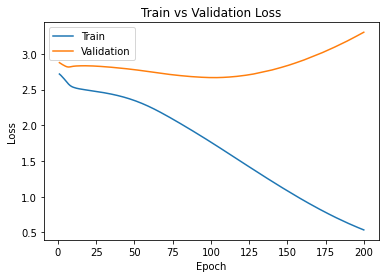

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 32, epoch = 199, learning_rate=0.001)
plot_training_curve(model_path)

# best val: Epoch 131: Train acc: 0.6178107606679035, Train loss: 1.3369542161623638 | Validation Accuracy: 0.208955223880597, Validation loss: 2.7305076122283936

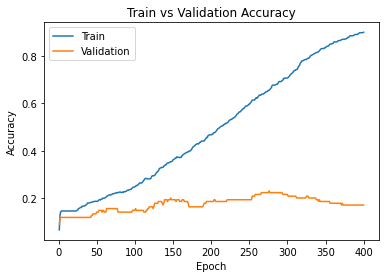

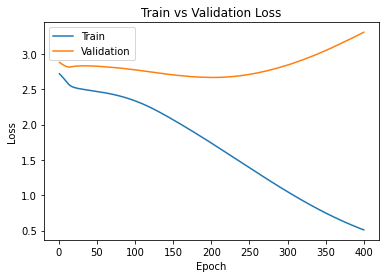

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 32, epoch = 399, learning_rate=0.0005)
plot_training_curve(model_path)

# best at Epoch 266: Train acc: 0.6382189239332097, Train loss: 1.2788088454140558 | Validation Accuracy: 0.22388059701492538, Validation loss: 2.743464994430542

# It looks like it's overfitting really easily. Potentially due to small dataset?

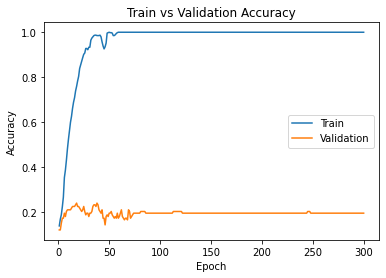

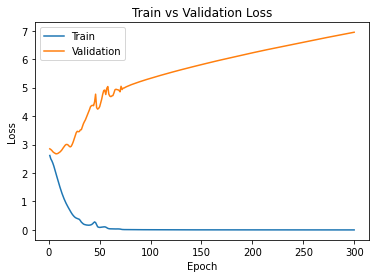

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 32, epoch = 299, learning_rate=0.0004)
plot_training_curve(model_path)

# switched to adam for optimizer
# Epoch 18: Train acc: 0.7588126159554731, Train loss: 0.8628204630480872 | Validation Accuracy: 0.23880597014925373, Validation loss: 3.002454948425293

In [ ]:
bestClassifier = mainClassifier()
model_path = get_model_name("mainClassifier3Layer", batch_size = 64, epoch = 73, learning_rate=0.001)
state = torch.load(model_path)
bestClassifier.load_state_dict(state)

criterion = nn.CrossEntropyLoss()
testEmedding = torch.load('/content/gdrive/MyDrive/Project/embeddings/' + "test64")
test_acc, test_loss = evaluate(bestClassifier, testEmedding, criterion)


print("Test accuracy is", test_acc, "Test loss is", test_loss)

Test accuracy is 0.3981623277182236 Test loss is 4.424333203922618


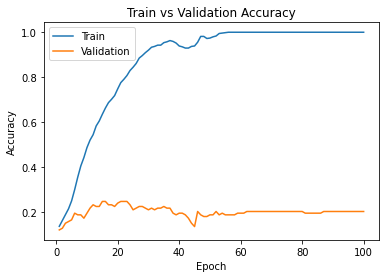

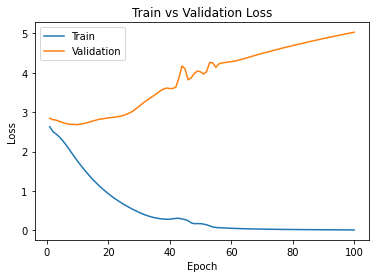

In [ ]:
model_path = get_model_name("mainClassifier3Layer", batch_size = 32, epoch = 99, learning_rate=0.0003)
plot_training_curve(model_path)